## 성능 최적화 종합실습 : Car seat sales

- 카시트에 대한 지역 매장별 매출액을 예측

### 1. 환경준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import * 

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 선형회귀용 전진선택법
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

def forward_stepwise_linear(x_train, y_train):

    # 변수목록, 선택된 변수 목록, 단계별 모델과 AIC 저장소 정의
    features = list(x_train)
    selected = []
    step_df = pd.DataFrame({ 'step':[], 'feature':[],'aic':[]})

    # 
    for s in range(0, len(features)) :
        result =  { 'step':[], 'feature':[],'aic':[]}

        # 변수 목록에서 변수 한개씩 뽑아서 모델에 추가
        for f in features :
            vars = selected + [f]
            x_tr = x_train[vars]
            model = OLS(y_train, add_constant(x_tr)).fit(disp=False)
            result['step'].append(s+1)
            result['feature'].append(vars)
            result['aic'].append(model.aic)
        
        # 모델별 aic 집계
        temp = pd.DataFrame(result).sort_values('aic').reset_index(drop = True)

        # 만약 이전 aic보다 새로운 aic 가 크다면 멈추기
        if step_df['aic'].min() < temp['aic'].min() :
            break
        step_df = pd.concat([step_df, temp], axis = 0).reset_index(drop = True)

        # 선택된 변수 제거
        v = temp.loc[0,'feature'][s]
        features.remove(v)

        selected.append(v)
    
    # 선택된 변수와 step_df 결과 반환
    return selected, step_df

In [3]:
# 변수 중요도 그래프
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df.reset_index(drop=True, inplace = True)

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.grid()

    return fi_df

In [4]:
data_path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/Carseats.csv'
data = pd.read_csv(data_path)

**변수설명**
> * Sales - 각 지역 판매량(단위 : 1000개) <== Target
* CompPrice - 각 지역 경쟁사 가격
* Income - 각 지역 평균 소득수준(단위 : 1000달러)
* Advertising - 각 지역, 회사의 광고 예산(단위 : 1000달러)
* Population - 지역 인구수(단위 : 1000명)
* Price - 자사 지역별 판매가격
* ShelveLoc - 진열상태
* Age - 지역 인구의 평균 연령
* Education - 각 지역 교육수준 레벨
* Urban - 매장 도시 지역 여부
* US - 매장이 미국에 있는지 여부

### 2. 데이터 이해

In [5]:
data.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [6]:
data.shape

(400, 11)

### 3. 데이터 준비

In [7]:
# feature engineering, feature drop
data['Diff_Price'] = data['CompPrice'] - data['Price']
data.drop('CompPrice', axis = 1, inplace = True)

In [8]:
# x, y 나누기
target = 'Sales'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

In [ ]:
# NA 조치

In [9]:
# 가변수화
dumm_cols = ['ShelveLoc', 'Urban', 'US']
x = pd.get_dummies(x, columns = dumm_cols, drop_first = True)

In [10]:
# train, valid 나누기
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=2022)

In [11]:
# Scaling
scaler = MinMaxScaler()

x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

### 4. 모델링

In [12]:
# SVM
params = {
    'C': np.linspace(0.01, 1.0, 100),
    'gamma': np.linspace(0.9, 1.0, 10)
}

In [13]:
svm = SVR()
svm_gs = GridSearchCV(svm, params, cv=5)
svm_gs.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ]),
                         'gamma': array([0.9       , 0.91111111, 0.92222222, 0.93333333, 0.94444444,
       0.95555556, 0.96666667, 0.97777778, 0.98888889, 1.        ])})

In [14]:
svm_gs.best_params_, svm_gs.best_score_

({'C': 0.04, 'gamma': 0.9}, -0.014042518333946274)

In [15]:
result_svm = pd.DataFrame(svm_gs.cv_results_)
temp = result_svm.loc[:, ['param_C', 'param_gamma', 'mean_test_score']]
temp.head()

,param_C,param_gamma,mean_test_score
0,0.01,0.9,-0.014267
1,0.01,0.911111,-0.014267
2,0.01,0.922222,-0.014267
3,0.01,0.933333,-0.014267
4,0.01,0.944444,-0.014267


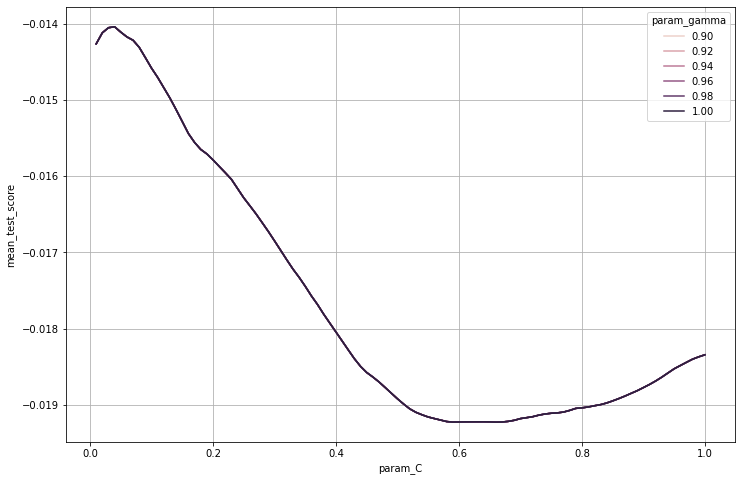

In [16]:
plt.figure(figsize = (12, 8))
sns.lineplot('param_C', 'mean_test_score', 
             data = temp,
             hue = 'param_gamma')
plt.grid()
plt.show()

In [17]:
# Random Forest
params = {
    'n_estimators': range(5, 201, 5),
    'max_features': range(3, 10),
}

In [18]:
rf = RandomForestRegressor()
rf_gs = GridSearchCV(rf, params, cv=5)
rf_gs.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': range(3, 10),
                         'n_estimators': range(5, 201, 5)})

In [19]:
rf_gs.best_params_, rf_gs.best_score_

({'max_features': 8, 'n_estimators': 115}, 0.7365414866251375)

In [20]:
result_rf = pd.DataFrame(rf_gs.cv_results_)
temp = result_rf.loc[:, ['param_n_estimators', 'param_max_features', 'mean_test_score']]
temp.head()

,param_n_estimators,param_max_features,mean_test_score
0,5,3,0.588857
1,10,3,0.610410
2,15,3,0.660667
3,20,3,0.680357
4,25,3,0.671799


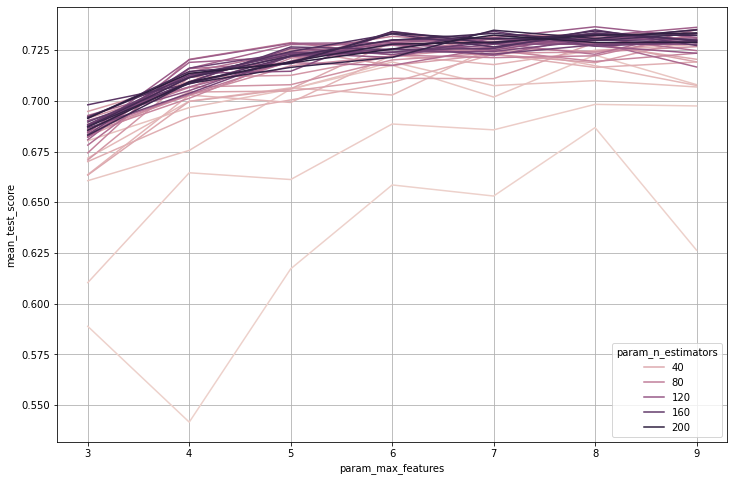

In [21]:
plt.figure(figsize = (12, 8))
sns.lineplot('param_max_features', 'mean_test_score', data = temp,
             hue = 'param_n_estimators')
plt.grid()
plt.show()

In [22]:
# XGB
params = {
    'n_estimators': range(1, 30, 1),
    'learning_rate': np.linspace(0.001, 0.1, 50),
}

In [23]:
xgb = XGBRegressor(objective = 'reg:squarederror')
xgb_gs = GridSearchCV(xgb, params, cv=5)
xgb_gs.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
       0.04140816, 0.04342857, 0.04544898, 0.04746939, 0.0494898 ,
       0.0515102 , 0.05353061, 0.05555102, 0.05757143, 0.05959184,
       0.06161224, 0.06363265, 0.06565306, 0.06767347, 0.06969388,
       0.07171429, 0.07373469, 0.0757551 , 0.07777551, 

In [24]:
xgb_gs.best_params_, xgb_gs.best_score_

({'learning_rate': 0.0979795918367347, 'n_estimators': 29}, 0.668950462463831)

In [26]:
pred_xgb = xgb_gs.predict(x_val)

In [27]:
result_xgb = pd.DataFrame(xgb_gs.cv_results_)
temp = result_xgb.loc[:, ['param_n_estimators', 'param_learning_rate', 'mean_test_score']]
temp.head()

,param_n_estimators,param_learning_rate,mean_test_score
0,1,0.001,-7.106975
1,2,0.001,-7.092279
2,3,0.001,-7.077612
3,4,0.001,-7.062972
4,5,0.001,-7.048361


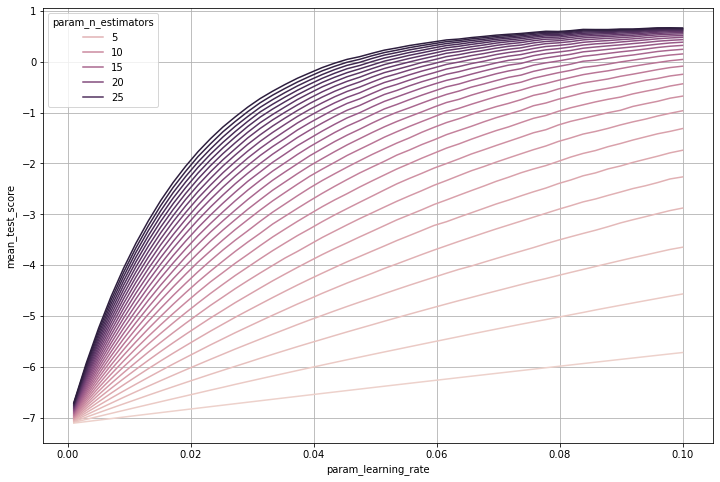

In [28]:
plt.figure(figsize = (12, 8))
sns.lineplot('param_learning_rate', 'mean_test_score', data = temp,
             hue = 'param_n_estimators')
plt.grid()
plt.show()